# <font color=darkblue>Deep learning for Non Intrusive Load Monitoring (NILM) - Part I</font>



## <font color=darkred> Bibliography & additional ressources </font>

- [1] https://github.com/nilmtk/nilmtk
``NILMTK is a toolkit designed to help researchers evaluate the accuracy of NILM algorithms``.
- [2] https://arxiv.org/pdf/2306.05017 `A nice review of deep learning for NILM``
- [3] https://github.com/ETSSmartRes/VAE-NILM
``Energy disaggregation using variational autoencoders``
- [4] https://github.com/Ming-er/NeuralNILM_Pytorch
``Several deep learning implementation for NILM including BiLSTM and CNN with attention``
- [5] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10099094/ ``New framework based on conditional diffusion models with nice bibliography``
- [6] https://github.com/k-nut/nilm-datasets/blob/master/nilm-datasets.csv ``Several NILM datasets``
- [7] https://arxiv.org/pdf/1904.05948 ``An algorithm to use VAE to perform regression``. This paper and the associated notebook https://colab.research.google.com/github/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb#scrollTo=WT4BekX2g4L_ for anomaly detection were used for the regression part of this notebook.

## <font color=darkred> Non intrusive load monitoring</font>


**Nonintrusive load monitoring (NILM)** or energy disaggregation is a process for analyzing detailed consumptions and deducing what **appliances are used** based on **aggregated data**.

Automated NILM provides valuable insights into energy usage behavior, and **fosters energy conservation, and optimize load management**.

![](https://www.researchgate.net/profile/Dea-Pujic/publication/342962857/figure/fig1/AS:929109328793602@1598528334547/Non-Intrusive-Load-Monitoring-concept.png)

NILM based on standard statistical approaches use mainly **Hidden Markov Model (HMM)**.

Deep learning-based solutions have brought new methodologies adopted from  Computer Vision, Natural Language Processing, Signal Processing: **attention mechanism, variational inference, recurrent neural networks**.

NILM is a severly **ill-posed inverse problem**. For instance, for the UK-dale dataset https://paperswithcode.com/dataset/uk-dale :

![](https://production-media.paperswithcode.com/datasets/Screenshot_2021-04-23_at_12.11.17.png)

**UK-DALE**: open-access dataset from the UK recording Domestic Appliance-Level Electricity. Provide the **aggregate demand per building** but also the **demand of individual appliances**.

Contains five houses, one of which was recorded for 655 days (at 16 kHz for the aggregate demand and at 1/6 Hz for individual appliances).

*Example outputs produced by neural network architectures for three appliances*
![](https://d3i71xaburhd42.cloudfront.net/7e629447855f235857cc2ae8d155a215f03fbf87/8-Figure2-1.png)

**Top row**: measured aggregate power data from House 1 (the input to the neural nets).

**Second row**: single-appliance power demand (i.e. the output to be predicted by the neural nets).

**Middle group of rows**: raw output from each neural network.

**Bottom group of rows**:  result of sliding the network over the aggregate data with STRIDE=16 and overlapping the output.

**Many solutions exist for highly instrumented houses and small buildings but there are no satisfactory solutions (nor datasets) for big buildings with few data**.

The problem still may be solved with additional exertnal information (weather, information on the building, transfer learning).

Using generative models to solve this problem requires:
- (i) Understanding <font color=darkblue> **training from scratch to understand each building block**</font> ;
- (ii.a) Understanding <font color=darkblue>**specific implementation for time series**</font> ;
- (ii.b) Understanding <font color=darkblue>**implementation with conditioning information**</font>.
- (iii) understanding how to use additional specific data (weather, occupation profile).

**In this notebook, we tacke problems (i) and (ii), problem (iii) is kept fort Part II with Accenta data**.

<font color=darkblue>**Data in the context of NILM**</font>
- Input time series $U$ containing weather information, scheduling, aggregated demand).
- Output time series $X$ to be predicted (individual appliances).


## <font color=darkred> VAE building blocks  in Torch </font>


### <font color=darkred> Reminder on variational inference, encoders and decoders</font>


The framework of variational autoencoders (VAEs) (Kingma and Welling,
2014; Rezende et al., 2014) provides a principled method for jointly
learning deep latent-variable models and corresponding inference models
using stochastic gradient descent.

Consider random variables $(Z,X)$ in $\mathbb{R}^d\times \mathbb{R}^m$ where $X$ is the observation and $Z$ is not observed. Assume that the distribution of $(Z,X)$ has a density $(z,x)\mapsto p_\theta(z,x)$ with respect to the Lebesgue measure. In this framework, we write
$$
(z,x)\mapsto p_\theta(z,x) = p_\theta(z)p_\theta(x|z)\,,
$$
where $z\mapsto p_\theta(z)$ is a prior density for $Z$ and $x \mapsto p_\theta(x|z)$ is the likelihood of $X$ given $Z$. We **do not** have access to the conditional distribution of $Z$ given $X$ in general as:
$$
z\mapsto p_\theta(z|x) = \frac{p_\theta(z)p_\theta(x|z)}{p_\theta(x)}\,,
$$
where $p_\theta(x) = \int p_\theta(z)p_\theta(x|z) \mathrm{d} z$ is an intractable integral.

**Example 1**.
Deep latent variable model for multivariate Benoulli data. In this setting, $X\in\{0,1\}^D$ and conditionally on a variable $Z\in\mathbb{R}^d$, $(X_1,\ldots,X_D)$ are independent with Bernoulli distribution with parameters ${\bf p}_\theta(Z) = (p_{1,\theta}(Z),\ldots, p_{D,\theta}(Z))$, where ${\bf p}_\theta(Z) $ is the output of a Multi-layer Perceptron with input $Z$ and parameters $\theta$ (weights and biases). In this example, the input variable has a prior distribution $Z\sim \mathcal{N}(0,I_d)$ and, for any value of $\theta$, the conditional distribution of $Z$ given $X$ is not available explicitly.

In varitional inference, we introduce a family of possible candidate distributions to approximate $z\mapsto p_\theta(z|x)$. Consider $\mathcal{D} = \{q_\phi\}_{\phi\in\Phi}$ where $\Phi$ is a parameter space and where  $q_\phi$ are chosen so that:

  - for all $\phi$, $q_\phi$ is easy to evaluate ;
  - for all $\phi$, $q_\phi$ is easy to sample.


The distribution $p_\theta(x|z)$ is referred to as the **decoder**. This is the distribution used to **reconstruct data from encoded vectors**.

The distribution $q_\varphi(z|x)$ is referred to as the **encoder**. This is the distribution used to **encode complex data in a simple latent space**.

*Illustration from [1]*.

![](https://d3i71xaburhd42.cloudfront.net/329b84a919bfd1771be5bd14fa81e7b3f74cc961/22-Figure2.1-1.png)

*Another classical illustration of a generic VAE*

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

### <font color=darkred>ELBO and loss function</font>


For all $x$ and all $\phi$,
\begin{align*}
\mathrm{KL}\left(q_\phi(\cdot|x)\|p_\theta(\cdot|x)\right) = \int q_\phi(z|x) \log \frac{q_\phi(z|x)}{p_\theta(z|x)} \mathrm{d}z&= \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z|x)]\,,\\
 &= \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z,x)]+\log p_\theta(x)\,,\\
&= -\mathcal{L}(\theta,\phi,x)+\log p_\theta(x)\,,
\end{align*}
where $\mathcal{L}(\theta,\phi,x) = \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z,x)]$. Using Jensen's inequality, note that $\mathrm{KL}\left(q_\phi\|p_\theta(\cdot|x)\right) \geq 0$ so that
$$
\mathcal{L}(\theta,\phi,x)\leq \log p_\theta(x)\,.
$$
This motivates the name Evidence Lower Bound  (ELBO) of the surrogate quantity to be optimized. In variational inference,   $p_\theta(\cdot|x)$ is estimated by  $q_{\phi_*}$ where :
$$
(\theta_*\phi_*) \in \mathrm{argmax}_{\phi\in\Phi}\;\frac{1}{n}\sum_{i=1}^n\mathcal{L}(\theta,\phi,x_i)\,,
$$
with $(x_i)_{1\leq i \leq n}$ i.i.d. data from the dataset. In practice, $\mathcal{L}(\theta,\phi,x_i)$ cannot be computed and is replaced by a Monte Carlo estimate, i.e. we sample $Z_i\sim q_\phi(\cdot|x)$ and we compute:
$$
\widehat{\mathcal{L}}(\theta,\phi,x_i) = \log q_\phi(Z_i|x_i) - \log p_\theta(Z_i,x_i)\,.
$$

### <font color=darkred> Summary</font>

<font color=darkblue>**In standard settings**</font>:
- Data set made of instances $(X_i)$, $1\leq i \leq n$.
- Each $X_i$ can be arbitrarily complex (in our case a multidimensional time series).
- We associate with each $X_i$ latent representations sampled with distribution $q_\varphi(z|X_i)$.

<font color=darkblue>**After training**</font> we can:
- Understand the latent representations $Z\sim q_\varphi(\cdot|X_i)$ to cluster data.
- For each $X_i$, sample $Z_i\sim q_\varphi(\cdot|X_i)$ and then $X\sim p_\theta(X|Z_i)$ to understand how well data are reconstructed.
- Sample new data by sampling $Z\sim p_\theta$ and $X\sim p_\theta(X|Z)$.

<font color=darkblue>**NILM Setting - several remarks**</font>
- Each $X_i$ is a multivariate time series of detailed consumptions $X_i = X_{t_1:t_2,i}$.
- We have acces to additional data $C_{t_1:t_2,i}$ (global consumptions, weather, profiles) and context features.

So we need to build sequences of latent data $Z_{t_1:t_2,i}$ in order to (at least) predict sharply detailed consumptions:
- Prior model $p_\theta(Z|C)$ and decoder $p_\theta(X|Z,C)$.
- Encoder $q_\varphi(Z|X,C)$.

### <font color=darkred> VAE with conditioning information </font>

For illustration we use a very well documented MNIST setting.

The code below is taken from  https://github.com/timbmg/VAE-CVAE-MNIST

<font color=darkblue>**Traditional VAE**</font>

The dataset is made of pictures of number between 0 and 9. So in this setting **$X_i$ is a matrix of size 28*28**. In a traditional VAE we model the decoder as
$$
(z,x)\mapsto p_\theta(z,x) = p_\theta(z)p_\theta(x|z)\,,
$$
and the encoder as
$$
q_\varphi(z|x)
$$
**After training**, we can for instance:
- **Sample new data** by sampling $z\sim p_\theta(z)$ and then $x\sim p_\theta(x|z)$.
- Encode $x$ using $q_\varphi(z|x)$ to produce $z$ and decode $z$ using $p_\theta(x|z)$ to analyze reconstructed data.

<font color=darkblue>**Conditional VAE**</font>

In the previsous setting **we do not use additional data such as the class of the numer we want to sample**. We can use conditioning to exploit this information and obtain better sampling. This **requires to adapt the model to the context and the architectures of the decoder and the decoder**.

In a conditional VAE we model the decoder as
$$
(z,x)\mapsto p_\theta(z,x|c) = p_\theta(z|c)p_\theta(x|c,z)\,,
$$
and the encoder as
$$
q_\varphi(z|x,c)
$$
**After training**, we can for instance:
- **Sample new data** by sampling $z\sim p_\theta(z|c)$ and then $x\sim p_\theta(x|c,z)$. The **latent vector and the observations use the context** !
- Encode $x$ using $q_\varphi(z|x,c)$ to produce $z$ using $c$ and decode $z$ using $p_\theta(x|c,z)$ to analyze reconstructed data.

*Unconditional training and sampling*

![](https://github.com/timbmg/VAE-CVAE-MNIST/raw/master/figs/1519649452.702026/E9I937.png)

*Conditional training and sampling*

![](https://github.com/timbmg/VAE-CVAE-MNIST/raw/master/figs/1519649461.195146/E9I937.png)

In [99]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)

    return onehot

In [100]:
import torch
import torch.nn as nn

class VAE(nn.Module):

    def __init__(self, encoder_layer_sizes, latent_size, decoder_layer_sizes,
                 conditional=False, num_labels=0):

        super().__init__()

        if conditional:
            assert num_labels > 0

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list

        self.latent_size = latent_size

        self.encoder = Encoder(
            encoder_layer_sizes, latent_size, conditional, num_labels)
        self.decoder = Decoder(
            decoder_layer_sizes, latent_size, conditional, num_labels)

    def forward(self, x, c=None):

        if x.dim() > 2:
            x = x.view(-1, 28*28)

        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z, c)

        return recon_x, means, log_var, z

    def reparameterize(self, mu, log_var):

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def inference(self, z, c=None):

        recon_x = self.decoder(z, c)

        return recon_x


class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.conditional = conditional
        if self.conditional:
            layer_sizes[0] += num_labels

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())

        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, c=None):

        if self.conditional:
            c = idx2onehot(c, n=10)
            x = torch.cat((x, c), dim=-1)

        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)

        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.MLP = nn.Sequential()

        self.conditional = conditional
        if self.conditional:
            input_size = latent_size + num_labels
        else:
            input_size = latent_size

        for i, (in_size, out_size) in enumerate(zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
            else:
                self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z, c):

        if self.conditional:
            c = idx2onehot(c, n=10)
            z = torch.cat((z, c), dim=-1)

        x = self.MLP(z)

        return x

In [103]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict

In [107]:
epochs=10
batch_size=64
learning_rate=0.001
encoder_layer_sizes=[784, 256]
decoder_layer_sizes=[256, 784]
latent_size=2
print_every=100
conditional=True

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ts = time.time()

dataset = MNIST(root='data', train=True, transform=transforms.ToTensor(),download=True)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 48636631.49it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1654994.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4290382.96it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6365027.99it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [106]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

In [108]:
vae = VAE(
    encoder_layer_sizes=encoder_layer_sizes,
    latent_size=latent_size,
    decoder_layer_sizes=decoder_layer_sizes,
    conditional=conditional,
    num_labels=10 if conditional else 0).to(device)

In [110]:
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

logs = defaultdict(list)

In [128]:
for epoch in range(epochs):

    tracker_epoch = defaultdict(lambda: defaultdict(dict))

    for iteration, (x, y) in enumerate(data_loader):

        x, y = x.to(device), y.to(device)

        if conditional:
            recon_x, mean, log_var, z = vae(x, y)
        else:
            recon_x, mean, log_var, z = vae(x)

        for i, yi in enumerate(y):
            id = len(tracker_epoch)
            tracker_epoch[id]['x'] = z[i, 0].item()
            tracker_epoch[id]['y'] = z[i, 1].item()
            tracker_epoch[id]['label'] = yi.item()

        loss = loss_fn(recon_x, x, mean, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logs['loss'].append(loss.item())

        if iteration % print_every == 0 or iteration == len(data_loader)-1:
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                epoch, epochs, iteration, len(data_loader)-1, loss.item()))

            if conditional:
                c = torch.arange(0, 10).long().unsqueeze(1).to(device)
                z = torch.randn([c.size(0), latent_size]).to(device)
                x = vae.inference(z, c=c)
            else:
                z = torch.randn([10, latent_size]).to(device)
                x = vae.inference(z)

Epoch 00/10 Batch 0000/937, Loss  137.0147
Epoch 00/10 Batch 0100/937, Loss  151.3408
Epoch 00/10 Batch 0200/937, Loss  141.6266
Epoch 00/10 Batch 0300/937, Loss  130.4316
Epoch 00/10 Batch 0400/937, Loss  128.1534
Epoch 00/10 Batch 0500/937, Loss  133.4988
Epoch 00/10 Batch 0600/937, Loss  136.6983
Epoch 00/10 Batch 0700/937, Loss  138.2803
Epoch 00/10 Batch 0800/937, Loss  123.0702
Epoch 00/10 Batch 0900/937, Loss  124.1987
Epoch 00/10 Batch 0937/937, Loss  127.0183
Epoch 01/10 Batch 0000/937, Loss  134.7078
Epoch 01/10 Batch 0100/937, Loss  139.5240
Epoch 01/10 Batch 0200/937, Loss  141.5423
Epoch 01/10 Batch 0300/937, Loss  124.1303
Epoch 01/10 Batch 0400/937, Loss  125.5192
Epoch 01/10 Batch 0500/937, Loss  125.2241
Epoch 01/10 Batch 0600/937, Loss  134.1070
Epoch 01/10 Batch 0700/937, Loss  121.1204
Epoch 01/10 Batch 0800/937, Loss  127.3437
Epoch 01/10 Batch 0900/937, Loss  136.0074
Epoch 01/10 Batch 0937/937, Loss  126.2203
Epoch 02/10 Batch 0000/937, Loss  135.9210
Epoch 02/10

In [120]:
# conditioning labels
c = torch.arange(0, 10).long().unsqueeze(1).to(device)
# sample a z for each label
z = torch.randn([c.size(0), latent_size]).to(device)
# sample an observation for each z
x = vae.inference(z, c=c)

In [124]:
c.shape

torch.Size([10, 1])

In [125]:
z.shape

torch.Size([10, 2])

In [126]:
x.shape

torch.Size([10, 784])

<Figure size 1400x700 with 0 Axes>

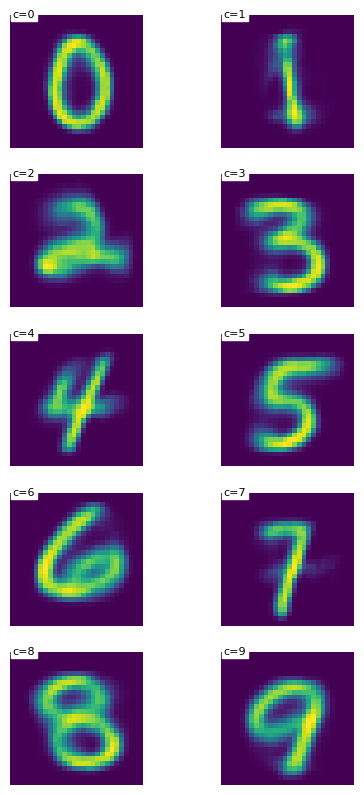

In [127]:
plt.figure()
plt.figure(figsize=(5, 10))
for p in range(10):
  plt.subplot(5, 2, p+1)
  plt.text(0, 0, "c={:d}".format(c[p].item()), color='black',backgroundcolor='white', fontsize=8)
  plt.imshow(x[p].view(28, 28).cpu().data.numpy())
  plt.axis('off')

Therefore we know how to perform conditional simulation. It remains to understand how to implement such models for <font color=darkblue>**regression problems and with time series inputs and outputs**</font>

### <font color=darkred> VAE for regression</font>

#### Import toy dataset

Artificial setting from scracth where we have acces to a time series in input adn want to predict one output (for instance a specific usage). In this case we will use a classic RMSE loss function.

In [1]:
import os
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
class RMSELoss(nn.Module):
	def __init__(self, eps=1e-6, reduction="mean"):
		super().__init__()
		self.mse = nn.MSELoss(reduction=reduction)
		self.eps = eps

	def forward(self, x_hat, x):
		return torch.sqrt(self.mse(x_hat, x)+self.eps)
mse = nn.MSELoss()
rmse = RMSELoss()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# Input features U
training_feature = np.loadtxt("/content/drive/My Drive/Colab Notebooks/NILM/U.txt")
# Observations Y
observations = np.loadtxt("/content/drive/My Drive/Colab Notebooks/NILM/X.txt")

In [33]:
training_feature.shape

(245, 301)

In [34]:
observations.shape

(245,)

In this setting, we have a **sequence of $245$ time steps with a one dimensional observation and an input of dimension $301$**. There are many possibilities to model the observation $x$, the latent data $z$ and the input features $c$.

If we want to model the **joint behavior of the input features and the observation** we can write:
$$
p_\theta(x,c) = \int p_\theta(z,x,c) \mathrm{d}z = \int p_\theta(z)p_\theta(u|z)p_\theta(x|c,z) \mathrm{d}z
$$

Then, we need to build the **encoder distribution i.e. the the behavior of the latent data given the observations** $q_\varphi(z|x,c)$.

Many choices are possible here and are often case-dependent. In the NILM setting, **we clearly do not want to model the input variables (weather, building properties)** and want to build directly a conditional model using $u$ as an input:
$$
p_\theta(x|c) = \int p_\theta(z,x|c) \mathrm{d}z = \int p_\theta(z|c)p_\theta(x|c,z) \mathrm{d}z
$$

But in this first part, in order to write the model from scratch we do not impose the use of a conditional model.

In [35]:
from torch.utils.data import Dataset

Tensor = torch.FloatTensor

class ToyDataset(Dataset):
    def __init__(self, x_data, y_data):
        super(ToyDataset, self).__init__()

        self.x = torch.Tensor(x_data)
        self.y = torch.Tensor(y_data)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

#### Model

The **encoder uses an input variable $U$** and produces:
- $p_\theta(x|u)$: Gaussian with mean ``dense_mu_x`` and log-variance ``dense_logvar_x``
- $q_\varphi(z|u)$: Gaussian with mean ``dense_mu_z`` and log-variance ``dense_logvar_z``

In [36]:
class Encoder(nn.Module):
    def __init__(self, intermidiate_dim, latent_dim):
        super(Encoder, self).__init__()
        # Build encoder model
        self.drop = nn.Dropout(0.25)
        self.dense1 = nn.Linear(301, 128)
        self.act1 = nn.Tanh()

        ## TODO : add a dense layer with output dimension = intermidiate_dim and tanh activation
        ##self.dense2 = nn.Linear(128, intermidiate_dim)
        ##self.act2 = nn.Tanh()

        self.model = nn.Sequential(self.dense1, self.act1, self.dense2, self.act2)

        self.dense_mu_x = nn.Linear(intermidiate_dim, 1)
        self.dense_logvar_x = nn.Linear(intermidiate_dim, 1)

        ## TO DO: compute mean and logvariance for the encoder
        ##self.dense_mu_z = nn.Linear(intermidiate_dim, latent_dim)
        ##self.dense_logvar_z = nn.Linear(intermidiate_dim, latent_dim)

        # latent generator
        self.dense_gen_z = nn.Linear(1, latent_dim)

    def sampling(self, mu, log_var):
        # Reparameterize
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        out = self.model(x)
        # z
        mu_z = self.dense_mu_z(out)
        logvar_z = self.dense_logvar_z(out)
        z = self.sampling(mu_z, logvar_z)

        mu_x = self.dense_mu_x(out)
        logvar_x = self.dense_logvar_x(out)
        xs = self.sampling(mu_x, logvar_x)

        # sample z conditionally to x
        z_bar_x = self.dense_gen_z(xs)

        return [mu_z, logvar_z, z], [mu_x, logvar_x, xs], z_bar_x


The **decoder uses an input variable $Z$** and produces:
- $p_\theta(c|z)$: ``Dirac mass`` centered at the output of the decoder.

In [37]:
class Decoder(nn.Module):
    def __init__(self, intermidiate_dim, latent_dim):
        super(Decoder, self).__init__()

        self.dense1 = nn.Linear(latent_dim, intermidiate_dim)
        self.act1 = nn.Tanh()


        ## TODO : add a dense layer with input dimension = intermidiate_dim and tanh activation and linear layer with output dimension = 301
        ##self.dense2 = nn.Linear(intermidiate_dim, 128)
        ##self.act2 = nn.Tanh()
        ##self.dense3 = nn.Linear(128, 301)

        self.model = nn.Sequential(self.dense1, self.act1,
                                   self.dense2, self.act2,
                                   self.dense3)
    def forward(self, x):
        return self.model(x)

#### Training

In [38]:
## Hyperparameters
intermidiate_dim = 32
batch_size = 32
latent_dim = 8
epochs = 50

# learning rate of the optimizer
lr = 0.0002
# hyperparameters for ADAM gradient descent
b1 = 0.5
b2 = 0.999
# number of folds, if we want to perform cross-validation
k_fold = 2

In [39]:
encoder = Encoder(intermidiate_dim=32, latent_dim=8)
decoder = Decoder(intermidiate_dim=32, latent_dim=8)

params = list(encoder.parameters()) + list(decoder.parameters())

optimizer = torch.optim.Adam(params, lr=lr, betas=(b1, b2))

In [40]:
skf = StratifiedKFold(n_splits=k_fold)
pred = np.zeros((observations.shape))

In [42]:
iterations = 1
obs = np.zeros((observations.shape[0]))
obs[:300] = 1
for train_idx, test_idx in skf.split(training_feature,obs):
    print("========== {0}th fold ==========".format(iterations))
    # split tr/tt dataset
    training_feature_sk = training_feature[train_idx,:]
    training_score = observations[train_idx].reshape(-1, 1)

    testing_feature_sk = training_feature[test_idx,:]
    testing_score = observations[test_idx].reshape(-1, 1)

    tr_dataset = ToyDataset(training_feature_sk, training_score)
    tt_dataset = ToyDataset(testing_feature_sk, testing_score)
    tr_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
    tt_loader = DataLoader(tt_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_vae_loss = 0
        for i, data in enumerate(tr_loader):
            x, target = data
            [mu_z, logvar_z, z], [mu_x, logvar_x, xs], z_bar_x = encoder(x)
            x_hat = decoder(z)

            # Loss from the reconstruction of the features
            # E[log p(c|z)]
            reconstruction_loss = mse(x, x_hat)
            # Loss from the divergence between the latent variable distributions
            # E[log p(z)/q(z|x,c)]
            kl_loss = 1 + logvar_z - torch.square(mu_z - z_bar_x) - torch.exp(logvar_z)
            kl_loss = -0.5 * torch.sum(kl_loss)
            # Loss from the reconstruction of the observations
            # E[log p(x|c)]
            obs_loss = torch.divide(0.5 * torch.square(mu_x - target), torch.exp(logvar_x)) + 0.5 *logvar_x

            # Total loss
            vae_loss = torch.mean(reconstruction_loss + kl_loss + obs_loss)


            total_vae_loss += vae_loss.item()
            vae_loss.backward()
            optimizer.step()

        # test phase
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            x = Tensor(testing_feature_sk)
            [mu_z, logvar_z, z], [mu_x, logvar_x, xs], z_bar_x = encoder(x)
            pred[test_idx] = np.array(mu_x.cpu().detach())[:,0]
            rmse_loss = rmse(mu_x, Tensor(testing_score))
        # print
        print("[Epoch: %d/%d] [Train loss: %.3f] ---> [Test RMSE: %.3f]" \
              % (epoch + 1, epochs, total_vae_loss/(i + 1), rmse_loss.item()))
    iterations += 1

========== 1th fold ==========
[Epoch: 1/50] [Train loss: 80.304] ---> [Test RMSE: 1.015]
[Epoch: 2/50] [Train loss: 85.226] ---> [Test RMSE: 0.976]
[Epoch: 3/50] [Train loss: 93.017] ---> [Test RMSE: 1.017]
[Epoch: 4/50] [Train loss: 78.396] ---> [Test RMSE: 1.153]
[Epoch: 5/50] [Train loss: 77.941] ---> [Test RMSE: 1.215]
[Epoch: 6/50] [Train loss: 83.641] ---> [Test RMSE: 1.172]
[Epoch: 7/50] [Train loss: 65.471] ---> [Test RMSE: 1.100]
[Epoch: 8/50] [Train loss: 66.108] ---> [Test RMSE: 1.041]
[Epoch: 9/50] [Train loss: 63.687] ---> [Test RMSE: 1.018]
[Epoch: 10/50] [Train loss: 51.810] ---> [Test RMSE: 1.026]
[Epoch: 11/50] [Train loss: 68.725] ---> [Test RMSE: 1.058]
[Epoch: 12/50] [Train loss: 41.403] ---> [Test RMSE: 1.103]
[Epoch: 13/50] [Train loss: 37.555] ---> [Test RMSE: 1.148]
[Epoch: 14/50] [Train loss: 44.290] ---> [Test RMSE: 1.178]
[Epoch: 15/50] [Train loss: 38.542] ---> [Test RMSE: 1.181]
[Epoch: 16/50] [Train loss: 35.035] ---> [Test RMSE: 1.151]
[Epoch: 17/50] [Tr

In [17]:
x, target = data

In [ ]:
## TO DO
## Check dimension of input and output data
## Chack that we can sample different observations using the decoder

In [19]:
#x.shape

torch.Size([27, 301])

In [18]:
#target.shape

torch.Size([27, 1])

In [48]:
#[mu_z, logvar_z, z], [mu_x, logvar_x, xs], z_bar_x = encoder(x)

In [38]:
#mu_z.shape

torch.Size([29, 8])

In [40]:
#logvar_z.shape

torch.Size([29, 8])

In [42]:
#z.shape

torch.Size([29, 8])

In [44]:
#mu_x.shape

torch.Size([29, 1])

In [45]:
#logvar_x.shape

torch.Size([29, 1])

In [46]:
#xs.shape

torch.Size([29, 1])

In [51]:
[mu_z, logvar_z, z], [mu_x, logvar_x, xs], z_bar_x = encoder(x)
x_hat = decoder(z)
import pandas as pd
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_hat.detach().numpy())

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])
principalDf.head()

,PC 1,PC 2
0,6.016008,-0.973229
1,-1.720423,-0.015110
2,4.232958,-0.670787
3,2.822503,3.066775
4,-2.213425,-1.765411


In [55]:
reconstruction_loss = mse(x, x_hat)
reconstruction_loss

tensor(0.9346, grad_fn=<MseLossBackward0>)

In [73]:
np.set_printoptions(precision=2)
plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

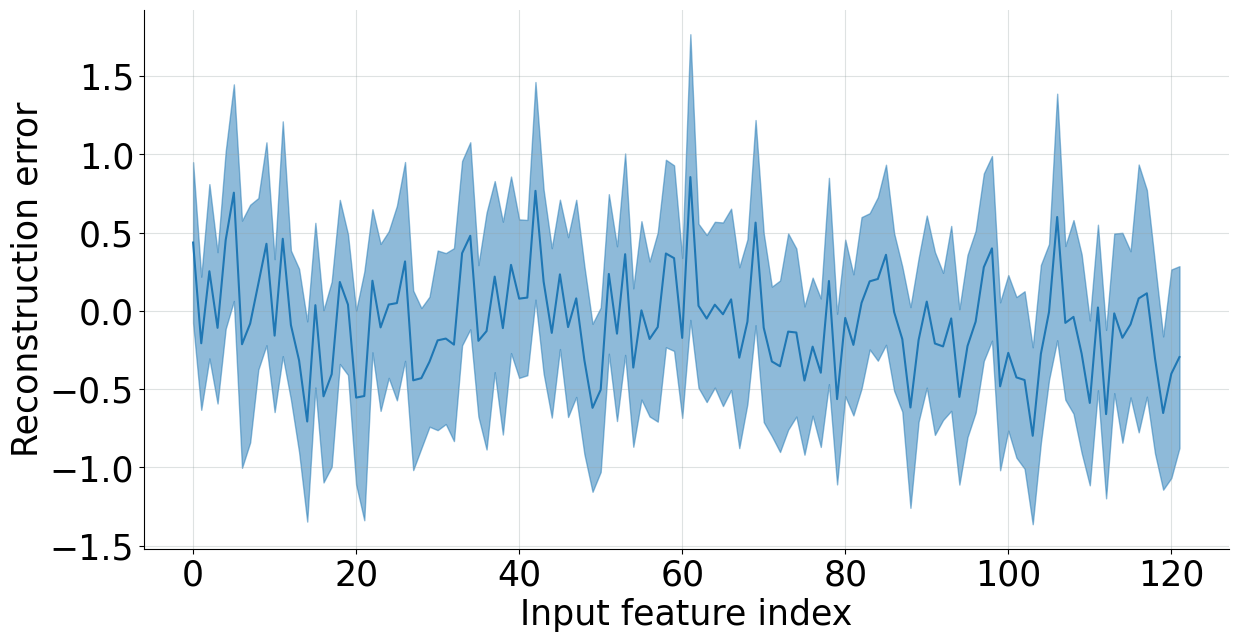

In [76]:
##TO DO: Plot the mean (and std) of the error for the reconstruction of each input
##mean_error = torch.mean(x-x_hat,axis=1)
##std_error = torch.std(torch.abs(x-x_hat),axis=1)

##plt.plot(mean_error.detach().numpy())

##ymoins = mean_error - std_error
##yplus = mean_error + std_error
##xplt = np.linspace(0, 121, 122)

##plt.xlabel("Input feature index")
##plt.ylabel("Reconstruction error")

##plt.fill_between(xplt,ymoins.detach().numpy(), yplus.detach().numpy(), color='C0', alpha=0.5);

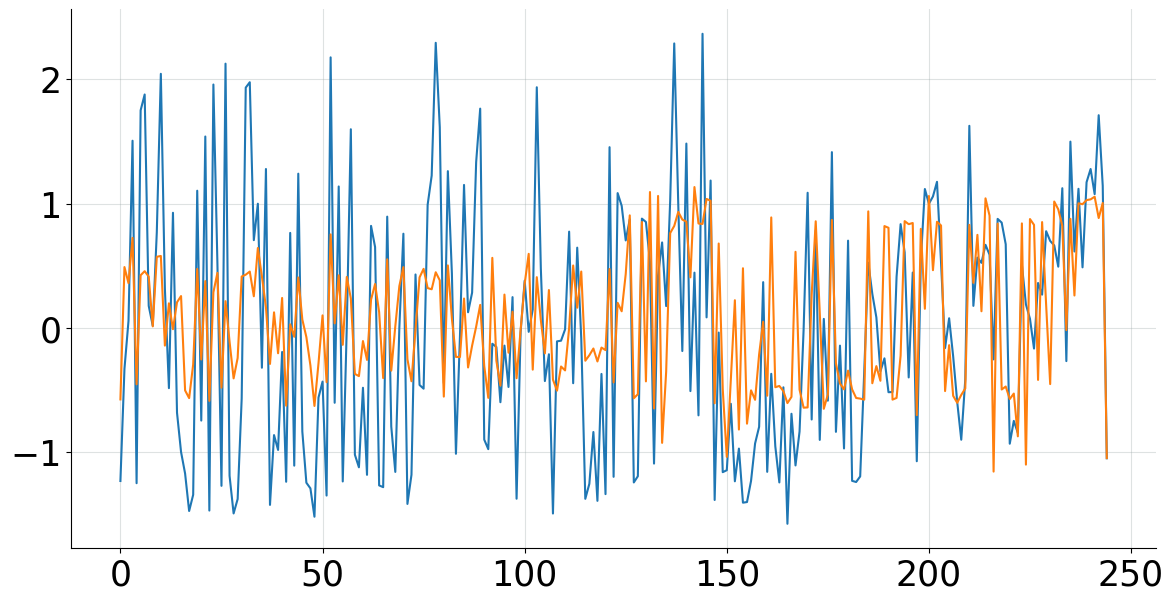

In [77]:
plt.plot(observations)
plt.plot(pred)

In [54]:
## Validation
print("Mean squared error: %.3f" % mean_squared_error(observations, np.array(pred)))
print('R2 Variance score: %.3f' % r2_score(observations, np.array(pred)))

Mean squared error: 0.140
R2 Variance score: 0.860


Text(0, 0.5, 'Predictions')

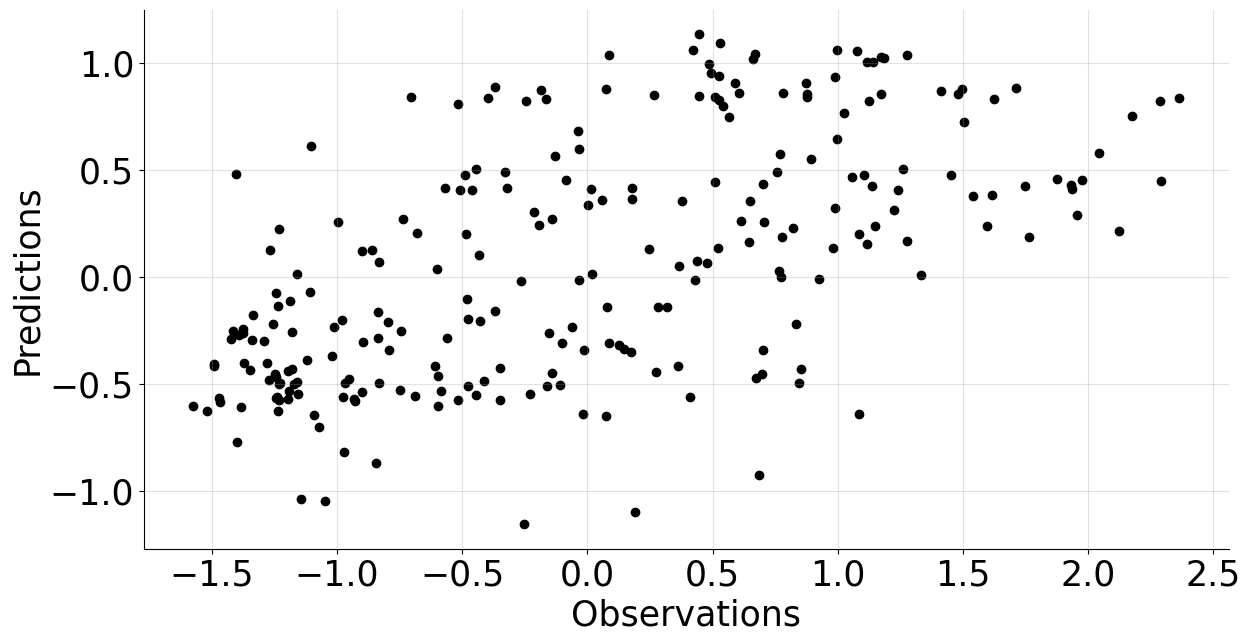

In [79]:
## TODO: Plot prediction vs. observations
##fig = plt.figure()
##ax = fig.add_subplot(111)
##ax.scatter(observations, np.array(pred),  color='black')
##plt.xlabel('Observations')
##plt.ylabel('Predictions')

## <font color=darkred> VAE from Trajectories/Time series </font>



As explained before, in the NILM setting, **we clearly do not want to model the input variables (weather, building properties)** and want to build directly a conditional model using $u$ as an input:
$$
p_\theta(x|c) = \int p_\theta(z,x|c) \mathrm{d}z = \int p_\theta(z|c)p_\theta(x|c,z) \mathrm{d}z
$$
This simplifies the construction of the model.

However, in the previous exmaple **we did not exploit at all the dependency of trajectories as we used dense networks**. It remains to build a VAE explicitly for time series using for instance RNN/LSTM/Attention mechanisms...

This is the topic of this Section.

In [129]:
import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from scipy.io import arff
from torch import nn, optim

import torch.nn.functional as F

##%matplotlib inline
##%config InlineBackend.figure_format='retina'

##sns.set(style='whitegrid', palette='muted', font_scale=1.2)
##rcParams['figure.figsize'] = 12, 8

The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.


We have 5 types of hearbeats (classes):
- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

**We do not want to perform classification here, simply to implement a VAE for time series with short sequences as it will be the case for NILM.**

In [81]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 135MB/s]


In [82]:
!unzip -qq ECG5000.zip

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [130]:
with open('ECG5000_TRAIN.arff') as f:
  train = arff.loadarff(f)
  train_data = pd.DataFrame(train[0])

with open('ECG5000_TEST.arff') as f:
  test = arff.loadarff(f)
  test_data = pd.DataFrame(test[0])

In [85]:
test_data.shape

(4500, 141)

In [131]:
class_names = ['Normal','R on T','PVC','SP','UB']

In [132]:
new_columns = list(train_data.columns)
new_columns[-1] = 'target'
train_data.columns = new_columns

In [133]:
new_columns = list(test_data.columns)
new_columns[-1] = 'target'
test_data.columns = new_columns

In [134]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

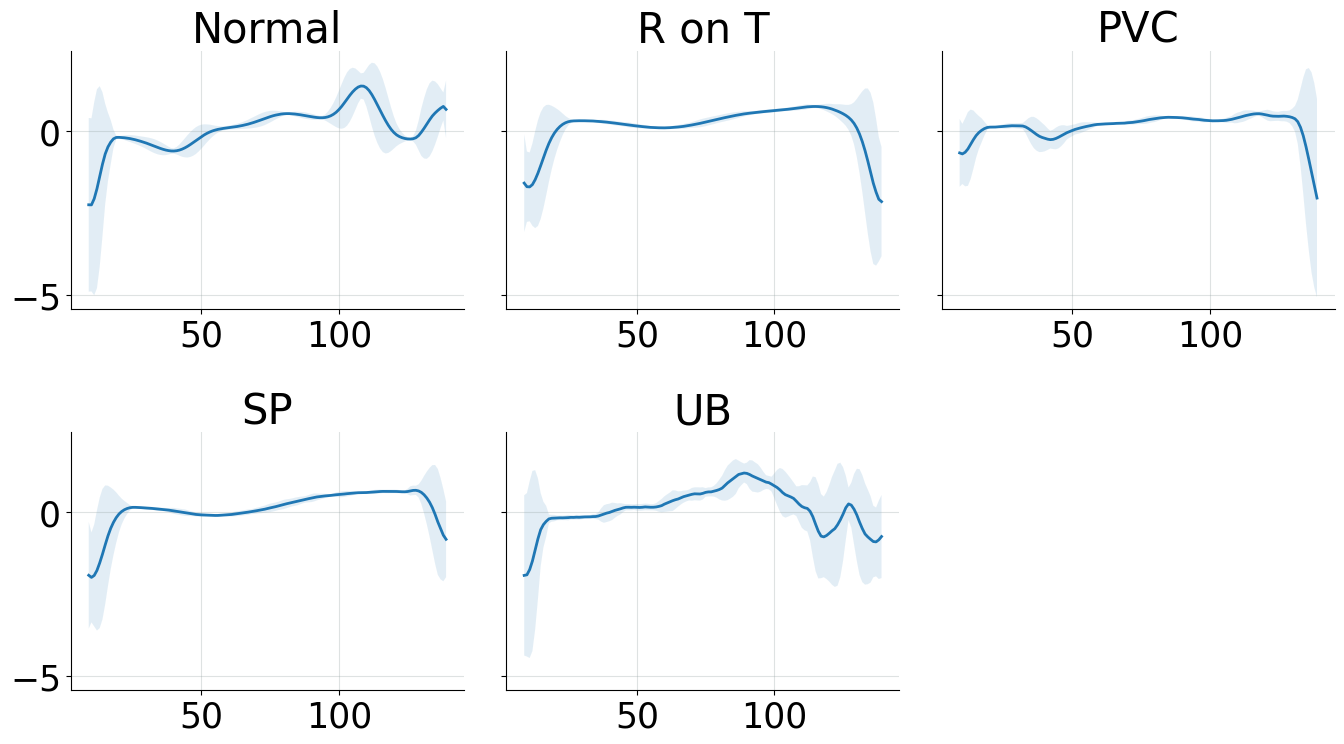

In [135]:
df = train_data
classes = train_data.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

#### Build dataset

In [136]:
df = df.drop(labels='target', axis=1)
df.shape

(500, 140)

In [137]:
train_df, val_df = train_test_split(df,test_size=0.3)

In [138]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

In [139]:
train_dataset, seq_len, n_features = create_dataset(train_df)

#### Encoder


In order to exploit the dependencies we use a LSTM-encoder. **Given the observation $x_{1:T}$, we build the latent data recursively $z_{1:T}$ using a LSTM cell**. This means that each latent data $z_t$ is built using recursively the observations and an inner state.

In our case:
$$
p_\theta(x_{1:T}|c_{1:T}) = \int p_\theta(z_{1:T},x_{1:T}|c_{1:T}) \mathrm{d}z_{1:T} = \int p_\theta(z_{1:T}|c_{1:T})p_\theta(x_{1:T}|c_{1:T},z_{1:T}) \mathrm{d}z\,.
$$

This means that <font color=darkblue>we need to model the **recursive decoder** $p_\theta(x_{1:T}|c_{1:T},z_{1:T})$ and the **recursive encoder** $q_\theta(z_{1:T}|c_{1:T},x_{1:T})$</font>.

In the cell below, we give en illustration (see also notebook on LSTM). If we use a one layer LSTM encoder, $h_t = z_t$, for multi-layer encoder, $h_t$ is used as input of the next cell an so on, $z_t$ being the output of the last cell

*A graphical model of a LSTM*.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Peephole_Long_Short-Term_Memory.svg/1280px-Peephole_Long_Short-Term_Memory.svg.png)

In [141]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    ## TO DO:
    ## Add a LSTM cell with output dimension given by embedding_dim
    ##self.rnn2 = nn.LSTM(
    ##input_size=self.hidden_dim,
    ##hidden_size=embedding_dim,
    ##num_layers=1,
    ##batch_first=True
    ##)

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

#### Decoder

Similarly, a LSTM is used to build the decoder and predict recursively $x_{1:t}$ given $z_{1:t}$.

In [143]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    ## TO DO:
    ## Add a LSTM cell with output dimension given by hidden_dim
    ##self.rnn2 = nn.LSTM(
    ##input_size=input_dim,
    ##hidden_size=self.hidden_dim,
    ##num_layers=1,
    ##batch_first=True
    ##)

    ## TODO: Add a linear cell to output the observation of dimension n_feature
    ##self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [144]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

#### Training

In [145]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [146]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [147]:
model, history = train_model(
  model,
  train_dataset,
  train_dataset,
  n_epochs=5
)

Epoch 1: train loss 90.42131438119071 val loss 88.66123607090542
Epoch 2: train loss 88.49043182373048 val loss 82.92705171857561
Epoch 3: train loss 72.16089105878558 val loss 66.92927353995186
Epoch 4: train loss 67.2682783290318 val loss 65.52899329049247
Epoch 5: train loss 66.53801261901856 val loss 65.61533107212611


In [148]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

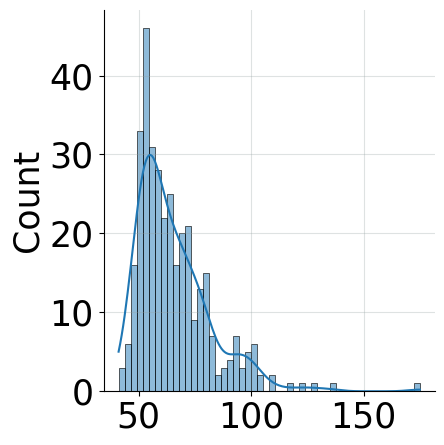

In [150]:
_, losses = predict(model, train_dataset)

sns.displot(losses, bins=50, kde=True);

## <font color=darkred> Applications to NILM </font>

See you for the next Lab !